<a href="https://colab.research.google.com/github/Pperezhogin/pyqg_generative/blob/master/Copy_of_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Needed only on Google Colab
try:
    import google.colab
    !pip install aiohttp requests zarr pyfftw gcm_filters pyqg
    !pip install git+https://github.com/m2lines/pyqg_generative.git
    print('\n------------- Packages on Google Colab are installed ------------')
except:
    print('\n------------- Not running on Google Colab --------------')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 12.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 88.3 MB/s eta 0:00:00
  Created wheel for pyqg: filename=pyqg-0.7.2-cp38-cp38-linux_x86_64.whl size=933181 sha256=28585954016d843888fbf8d6e074d844c4f6f0aaf2cf64a42bdf118190f7e4a6
  Stored in directory: /root/.cache/pip/wheels/a2/e3/ed/02db1e393bf087cc9729ef23e34080ea15cdc6322dbc0aace7
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=b9ae456d1798ecf15d6f4a48e9a2c4eb8981d393b6fa86225affa

In [ ]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt

In [ ]:
def open_zarr(folder):
    for url, label in zip(['https://g-402b19.00888.8540.data.globus.org', 'https://g-771f59.00888.8540.data.globus.org'], ['archive', 'scratch']):
      try:
        mapper = fsspec.get_mapper(f'{url}/{folder}.zarr')
        return xr.open_zarr(mapper, consolidated=True)
      except:
        print(f'{folder} on {label} failed')

In [ ]:
if True:
    # Try training on subset of data
    train_size = 5
    test_size = 2
    time_size = 5
else:
    # Full dataset
    train_size = 250
    test_size = 25
    time_size = None

In [ ]:
ds = open_zarr('eddy/48/sharp')
train = ds.isel(run=slice(0,train_size), time=slice(0,time_size)).load()
test = ds.isel(run=slice(train_size,train_size+test_size), time=slice(0,time_size)).load()

# Training of the GAN model and saving to 'GAN' folder

In [ ]:
from pyqg_generative.models.cgan_regression import CGANRegression
gan = CGANRegression(nx=48, folder='GAN')

In [ ]:
gan.fit(train, test)

Training starts on device Tesla T4, number of samples 25
[1/200] [6.60/1314.01] D_loss: 0.01 G_loss: -0.02 L2_mean: [1.000,1.000] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
[2/200] [0.50/702.97] D_loss: -0.04 G_loss: -0.08 L2_mean: [1.000,1.000] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
[3/200] [0.50/498.82] D_loss: -0.09 G_loss: -0.17 L2_mean: [1.000,1.000] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
[4/200] [0.49/396.35] D_loss: -0.16 G_loss: -0.30 L2_mean: [1.000,1.000] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
[5/200] [0.49/334.55] D_loss: -0.26 G_loss: -0.55 L2_mean: [1.000,1.000] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
[6/200] [0.49/293.23] D_loss: -0.41 G_loss: -0.98 L2_mean: [1.000,1.000] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
[7/200] [0.49/263.65] D_loss: -0.66 G_loss: -1.76 L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
[8/200] [0.50/241.56] D_loss: -1.06 G_loss: -3.29 L2_mean: [1.002,1.002] L2_total: [1.000,1.000] L2_res: [1.00

#Read the GAN model from the disk

In [ ]:
import json
def read_model(folder):
  with open(f'{folder}/model_args.json') as file:
    model_args = json.load(file)
    return eval(model_args.pop('model'))(**model_args)

In [ ]:
gan = read_model('GAN')

#Plotting training loss and metrics

In [ ]:
stats = xr.open_dataset('GAN/stats.nc')

In [ ]:
stats

<xarray.Dataset>
Dimensions:           (epoch: 200, lev: 2)
Coordinates:
  * epoch             (epoch) int64 1 2 3 4 5 6 7 ... 195 196 197 198 199 200
  * lev               (lev) int64 1 2
Data variables: (12/13)
    D_grad            (epoch) float64 ...
    G_loss            (epoch) float64 ...
    D_drift           (epoch) float64 ...
    D_loss            (epoch) float64 ...
    L2_mean           (epoch) float64 ...
    L2_total          (epoch) float64 ...
    ...                ...
    var_ratio         (epoch, lev) float32 ...
    L2_mean_test      (epoch) float64 ...
    L2_total_test     (epoch) float64 ...
    L2_residual_test  (epoch) float64 ...
    loss              (epoch) float64 ...
    Epoch_opt         float64 ...

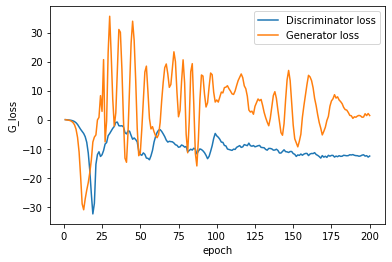

In [ ]:
stats.D_loss.plot(label='Discriminator loss')
stats.G_loss.plot(label='Generator loss')
plt.legend()

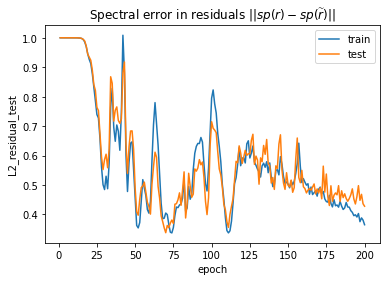

In [ ]:
stats.L2_residual.plot(label='train')
stats.L2_residual_test.plot(label='test')
plt.title('Spectral error in residuals $||sp(r)-sp(\widetilde{r})||$')
plt.legend()

#Train VAE model

In [ ]:
from pyqg_generative.models.cvae_regression import CVAERegression
vae = CVAERegression(folder='VAE')

In [ ]:
vae.fit(train, test)

Training starts on device Tesla T4, number of samples 25
[1/200] [0.56/110.52] MSE/KL: [1.329, 1270.601] Var: [1.145,1.515] L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000] Var_ratio: [0.000, 0.000]
[2/200] [0.56/110.34] MSE/KL: [1.272, 1053.743] Var: [1.117,1.421] L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000] Var_ratio: [0.000, 0.000]
[3/200] [0.48/105.42] MSE/KL: [1.223, 952.416] Var: [1.104,1.376] L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000] Var_ratio: [0.000, 0.000]
[4/200] [0.47/101.59] MSE/KL: [1.184, 875.513] Var: [1.090,1.342] L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000] Var_ratio: [0.000, 0.000]
[5/200] [0.47/99.17] MSE/KL: [1.142, 813.996] Var: [1.078,1.315] L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000] Var_ratio: [0.000, 0.000]
[6/200] [0.48/97.66] MSE/KL: [1.085, 761.308] Var: [1.068,1.291] L2_mean: [1.001,1.001] L2_total: [1.000,1.000] L2_res: [1.000,1.000] Var

In [ ]:
del vae
vae = read_model('VAE')

#Train GZ model

In [ ]:
from pyqg_generative.models.mean_var_model import MeanVarModel
gz = MeanVarModel(folder='GZ')

In [ ]:
gz.fit(train, test)

Training starts on device Tesla T4, number of samples 25
[1/50] [0.07/3.44] Loss: [1.354, 1.068]
[2/50] [0.07/3.36] Loss: [1.263, 1.069]
[3/50] [0.07/3.27] Loss: [1.126, 1.069]
[4/50] [0.06/3.10] Loss: [1.082, 1.070]
[5/50] [0.05/2.92] Loss: [1.058, 1.070]
[6/50] [0.06/2.80] Loss: [1.042, 1.070]
[7/50] [0.05/2.68] Loss: [1.032, 1.070]
[8/50] [0.05/2.58] Loss: [1.026, 1.070]
[9/50] [0.06/2.53] Loss: [1.021, 1.070]
[10/50] [0.05/2.44] Loss: [1.017, 1.070]
[11/50] [0.05/2.36] Loss: [1.014, 1.070]
[12/50] [0.05/2.28] Loss: [1.012, 1.070]
[13/50] [0.06/2.21] Loss: [1.010, 1.070]
[14/50] [0.06/2.14] Loss: [1.008, 1.070]
[15/50] [0.06/2.08] Loss: [1.007, 1.070]
[16/50] [0.05/2.01] Loss: [1.006, 1.070]
[17/50] [0.05/1.95] Loss: [1.006, 1.070]
[18/50] [0.05/1.88] Loss: [1.005, 1.070]
[19/50] [0.06/1.82] Loss: [1.004, 1.070]
[20/50] [0.05/1.76] Loss: [1.004, 1.070]
[21/50] [0.05/1.69] Loss: [1.004, 1.070]
[22/50] [0.05/1.63] Loss: [1.003, 1.070]
[23/50] [0.05/1.57] Loss: [1.003, 1.070]
[24/50] [

RuntimeError: ignored

In [ ]:
del gz
gz = read_model('GZ')